In [3]:
# MNIST immage classification
# from sklearn.datasets import fetch_mldata
# mnist = fetch_mldata('MNIST original')
# mnist
from sklearn.datasets.base import get_data_home 
print (get_data_home())

C:\Users\ishant.wankhede\scikit_learn_data


> MNIST : setting up the dataset.

Success!
{'DESCR': 'mldata.org dataset: mnist-original', 'data': array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), 'target': array([0., 0., 0., ..., 9., 9., 9.]), 'COL_NAMES': ['label', 'data']}
(array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8), array([0., 0., 0., ..., 9., 9., 9.]))


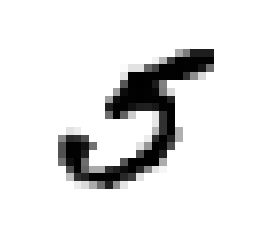

5.0


In [4]:
from six.moves import urllib
from sklearn.datasets import fetch_mldata

from scipy.io import loadmat
# mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
mnist_path = "./mnist-original.mat"
# response = urllib.request.urlopen(mnist_alternative_url)
# with open(mnist_path, "wb") as f:
#     content = response.read()
#     f.write(content)
mnist_raw = loadmat(mnist_path)
mnist = {
    "data": mnist_raw["data"].T,
    "target": mnist_raw["label"][0],
    "COL_NAMES": ["label", "data"],
    "DESCR": "mldata.org dataset: mnist-original",
}
print("Success!")

print(mnist)
X, y = mnist["data"], mnist["target"]
print(X,y)
X.shape, y.shape

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28,28)
plt.imshow(some_digit_image, cmap = matplotlib.cm.binary, interpolation = "nearest")
plt.axis("off")
plt.show()

print(y[36000])
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
import numpy as np
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Training a Binary Classifier

We will simplify the problem and only try to identify one digit at a time for eg 5. This '5-detector' will be and example of a binary classifier.

In [5]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [6]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)
sgd_clf.predict([some_digit])

C:\Users\ishant.wankhede\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


array([ True])

## Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor.

>Measuring accuracy using Cross Validation

the cross_val_score() function to evaluate your SGDClassifier model using K-fold crossvalidation,
with three folds. 

In [7]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95905, 0.96145, 0.9594 ])

Do you think this accuracy number is good? Let try a fit a model which predicts that "no image is 5"

In [8]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.90855, 0.91075, 0.90965])

As we can see that even this has high accuracy, that means the dataset is skewed.

In [10]:
# print(len(y_train_5), sum(y_train_5))
# (60000,5421) That means less than 10% is 5

This demonstrates why accuracy is generally not the preferred performance measure for classifiers,
especially when you are dealing with skewed datasets (i.e., when some classes are much more frequent
than others).

### Confusion Matrix https://en.wikipedia.org/wiki/Confusion_matrix

In [11]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53751,   828],
       [ 1574,  3847]], dtype=int64)

* Precision (Accuracy of the positive prediction) : TP / (TP + FP)
* Recall (Sensitivty / True Positive Rate) : TP / (TP + FN)

In [20]:
from sklearn.metrics import precision_score, recall_score
print("Precision ", precision_score(y_train_5, y_train_pred))
print("Recall ", recall_score(y_train_5, y_train_pred))
from sklearn.metrics import f1_score
print("F1 Score ", f1_score(y_train_5, y_train_pred))

('Precision ', 0.8228877005347593)
('Recall ', 0.7096476664821989)
('F1 Score ', 0.7620839936608558)
